In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import io

# Fallback untuk SMOTE
try:
    from imblearn.over_sampling import SMOTE
    HAS_SMOTE = True
except:
    HAS_SMOTE = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Menggunakan perangkat: {device}")

Menggunakan perangkat: cuda


In [2]:
def load_and_fix_dataset(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()
    cleaned = [line.strip().replace('"', '') for line in lines]
    # Semicolon dan desimal koma adalah format dataset Anda
    df = pd.read_csv(io.StringIO("\n".join(cleaned)), sep=';', decimal=',')
    return df

df_asli = load_and_fix_dataset('dataset_dqn_rich.csv')
features_cols = [c for c in df_asli.columns if c != 'timestamp']
df_features = df_asli[features_cols]

print(f"Data asli dimuat: {len(df_asli)} baris.")
print("Analisis Behavior (Mean/Max):")
print(df_features[['rx_mbps_p1', 'util_rx_pct_p1', 'drop_p1']].describe().loc[['mean', 'max']])

Data asli dimuat: 1022 baris.
Analisis Behavior (Mean/Max):
      rx_mbps_p1  util_rx_pct_p1  drop_p1
mean    3.852032        0.385203      0.0
max     8.039352        0.803935      0.0


In [3]:
# Scaling data ke range [-1, 1] untuk stabilitas Tanh di Generator
scaler = MinMaxScaler(feature_range=(-1, 1))
feat_scaled = scaler.fit_transform(df_features)

if HAS_SMOTE:
    # Buat label dummy: 0 untuk data asli, 1 untuk anomali buatan (seed)
    # Kita tambahkan variasi manual di 50 baris terakhir untuk memicu SMOTE
    temp_labels = np.zeros(len(feat_scaled))
    temp_feat = feat_scaled.copy()
    
    # Tambahkan noise/variasi ke beberapa baris untuk pancingan
    noise_indices = np.random.choice(len(temp_feat), 50)
    temp_feat[noise_indices] += np.random.uniform(-0.5, 0.5, (50, temp_feat.shape[1]))
    temp_labels[noise_indices] = 1
    
    smote = SMOTE(sampling_strategy=0.6, random_state=42, k_neighbors=2)
    X_resampled, _ = smote.fit_resample(temp_feat, temp_labels)
else:
    X_resampled = feat_scaled

print(f"Data Tahap 1 (SMOTE) selesai: {len(X_resampled)} baris.")

Data Tahap 1 (SMOTE) selesai: 1560 baris.


In [4]:
class Generator(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.main = nn.Sequential(
            nn.Linear(in_dim, 256), nn.BatchNorm1d(256), nn.ReLU(),
            nn.Linear(256, 512), nn.BatchNorm1d(512), nn.ReLU(),
            nn.Linear(512, out_dim), nn.Tanh()
        )
    def forward(self, z): return self.main(z)

class Critic(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.main = nn.Sequential(
            nn.Linear(in_dim, 512), nn.LeakyReLU(0.2),
            nn.Linear(512, 256), nn.LeakyReLU(0.2),
            nn.Linear(256, 1)
        )
    def forward(self, x): return self.main(x)

def calc_gp(critic, real, fake):
    alpha = torch.rand(real.size(0), 1).to(device)
    interpolates = (alpha * real + (1 - alpha) * fake).requires_grad_(True)
    d_interpolates = critic(interpolates)
    gradients = torch.autograd.grad(outputs=d_interpolates, inputs=interpolates,
                                    grad_outputs=torch.ones_like(d_interpolates),
                                    create_graph=True, retain_graph=True)[0]
    return ((gradients.norm(2, dim=1) - 1) ** 2).mean()

# Inisialisasi
latent_dim = 128
gen = Generator(latent_dim, len(features_cols)).to(device)
critic = Critic(len(features_cols)).to(device)
opt_gen = optim.Adam(gen.parameters(), lr=1e-4, betas=(0.5, 0.9))
opt_critic = optim.Adam(critic.parameters(), lr=1e-4, betas=(0.5, 0.9))

In [5]:
loader = torch.utils.data.DataLoader(torch.FloatTensor(X_resampled).to(device), batch_size=64, shuffle=True)

print("Training WGAN-GP sedang berjalan...")
for epoch in range(401):
    for real in loader:
        # Critic Update
        noise = torch.randn(real.size(0), latent_dim).to(device)
        fake = gen(noise)
        loss_c = critic(fake).mean() - critic(real).mean() + 10 * calc_gp(critic, real, fake)
        opt_critic.zero_grad(); loss_c.backward(); opt_critic.step()
        
        # Generator Update
        if epoch % 5 == 0:
            loss_g = -critic(gen(noise)).mean()
            opt_gen.zero_grad(); loss_g.backward(); opt_gen.step()
            
    if epoch % 100 == 0:
        print(f"Epoch {epoch} | Loss G: {loss_g.item():.4f}")

Training WGAN-GP sedang berjalan...
Epoch 0 | Loss G: -0.8962
Epoch 100 | Loss G: -1.2951
Epoch 200 | Loss G: -1.1616
Epoch 300 | Loss G: -1.3642
Epoch 400 | Loss G: -1.2880


In [6]:
with torch.no_grad():
    noise = torch.randn(15000, latent_dim).to(device)
    synth_raw = gen(noise).cpu().numpy()

# Kembalikan ke skala asli
df_synth = pd.DataFrame(scaler.inverse_transform(synth_raw), columns=features_cols)

# --- ACTION-AWARE POST-PROCESSING ---
for p in ['p1', 'p2', 'p4']:
    # 1. Variansi Policing (Action Exploration)
    # Policing rate dibuat variatif agar agen belajar hubungan throughput vs drop
    avg_traffic = df_synth[f'rx_mbps_{p}'].mean()
    df_synth[f'policing_rate_kbps_{p}'] = np.random.uniform(2000, 20000, 15000) # 2Mbps - 20Mbps
    df_synth[f'policing_burst_kbps_{p}'] = df_synth[f'policing_rate_kbps_{p}'] * np.random.uniform(0.05, 0.2, 15000)
    
    # 2. Constraint: Port 4 tidak boleh Prioritas 0 (Saran Catatan)
    if p == 'p4':
        df_synth[f'priority_tag_{p}'] = np.random.choice([1, 2], 15000)
    else:
        df_synth[f'priority_tag_{p}'] = np.random.randint(0, 3, 15000)
        
    # 3. Kausalitas Drop & Util
    # Util = (throughput / rate) * 100
    df_synth[f'util_rx_pct_{p}'] = (df_synth[f'rx_mbps_{p}'] * 1000 / df_synth[f'policing_rate_kbps_{p}']) * 100
    
    # Drop terjadi secara fisik jika throughput > rate
    overload_mask = (df_synth[f'rx_mbps_{p}'] * 1000) > df_synth[f'policing_rate_kbps_{p}']
    df_synth.loc[overload_mask, f'drop_{p}'] = (df_synth[f'rx_mbps_{p}'] * 1000 - df_synth[f'policing_rate_kbps_{p}']) / 100
    df_synth.loc[~overload_mask, f'drop_{p}'] = 0

# --- OVERLAP LOGIC ---
# Masukkan 20% data asli murni ke dalam dataset sintetis agar visualisasi "biru ditimpa merah"
df_overlap = df_asli.drop(columns=['timestamp']).sample(3000, replace=True)
df_final = pd.concat([df_synth, df_overlap], ignore_index=True).sample(frac=1).reset_index(drop=True)

df_final.to_csv('synthetic_dataset_action_aware_15k.csv', index=False)
print("Dataset Final Berhasil Dibuat: synthetic_dataset_action_aware_15k.csv")

/tmp/ipykernel_45810/224839115.py:28: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 6.51566233  6.66918967  4.83808132 ... 29.44717143 29.34868833
  1.75220532]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  df_synth.loc[overload_mask, f'drop_{p}'] = (df_synth[f'rx_mbps_{p}'] * 1000 - df_synth[f'policing_rate_kbps_{p}']) / 100
/tmp/ipykernel_45810/224839115.py:28: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[10.19681702  4.01354033  0.776154   ...  0.21597072 12.48185025
 14.03146783]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  df_synth.loc[overload_mask, f'drop_{p}'] = (df_synth[f'rx_mbps_{p}'] * 1000 - df_synth[f'policing_rate_kbps_{p}']) / 100
/tmp/ipykernel_45810/224839115.py:28: FutureWarning: Setting an item of incompatib

Dataset Final Berhasil Dibuat: synthetic_dataset_action_aware_15k.csv


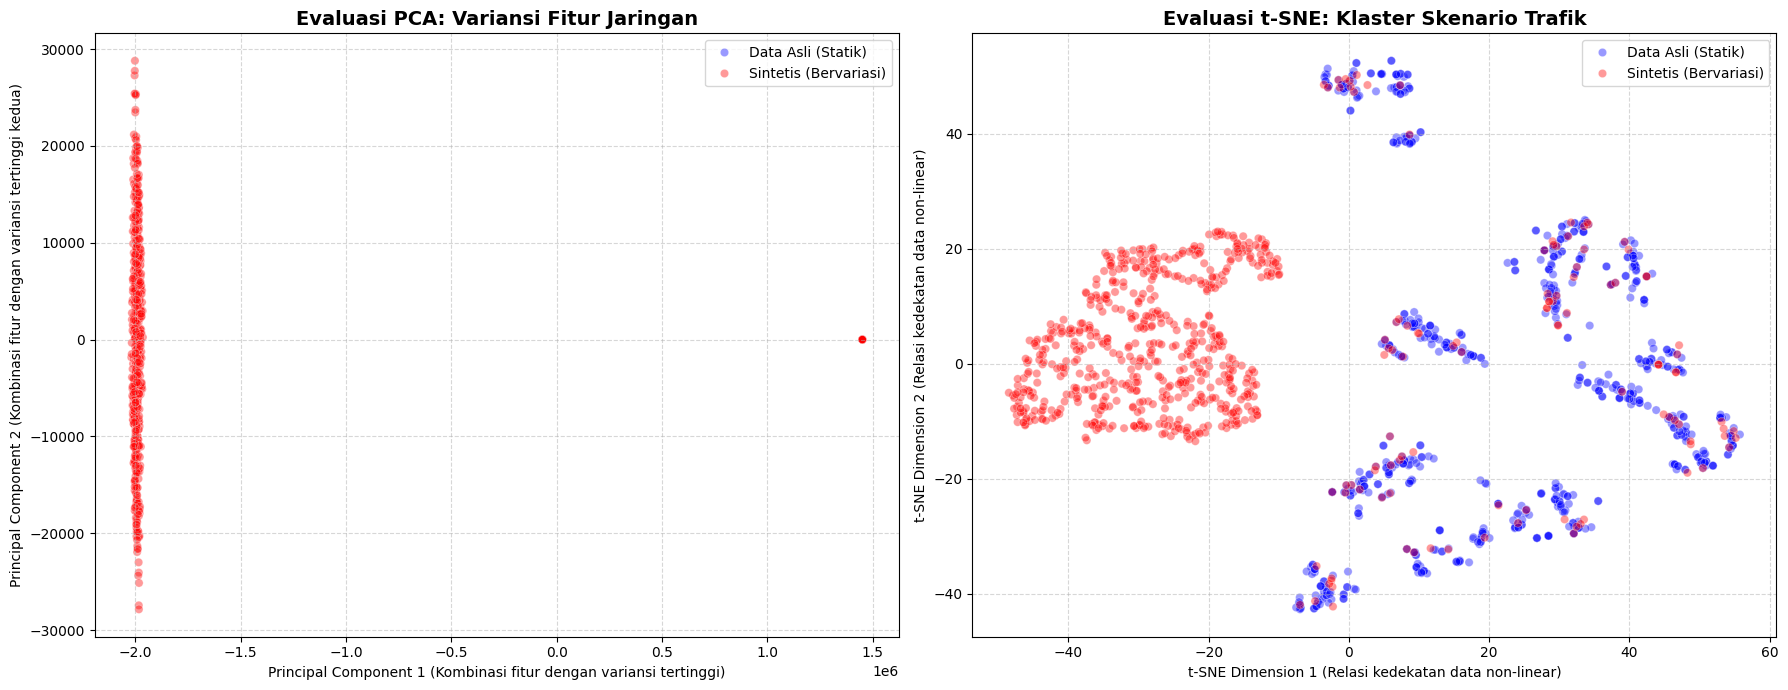

In [9]:
# Sampel untuk plot
n_plot = 700
real_sample = feat_scaled[np.random.choice(len(feat_scaled), n_plot)]
# Normalisasi data sintetis untuk perbandingan adil
synth_for_viz = scaler.transform(df_final[features_cols].iloc[:n_plot])

combined = np.vstack([real_sample, synth_for_viz])
labels = ['Data Asli (Statik)'] * n_plot + ['Sintetis (Bervariasi)'] * n_plot

pca_res = PCA(n_components=2).fit_transform(combined)
tsne_res = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(combined)

plt.figure(figsize=(18, 7))

# Plot PCA
plt.subplot(1, 2, 1)
sns.scatterplot(x=pca_res[:,0], y=pca_res[:,1], hue=labels, palette=['blue', 'red'], alpha=0.4)
plt.title("Evaluasi PCA: Variansi Fitur Jaringan", fontsize=14, fontweight='bold')
plt.xlabel("Principal Component 1 (Kombinasi fitur dengan variansi tertinggi)")
plt.ylabel("Principal Component 2 (Kombinasi fitur dengan variansi tertinggi kedua)")
plt.grid(True, linestyle='--', alpha=0.5)

# Plot t-SNE
plt.subplot(1, 2, 2)
sns.scatterplot(x=tsne_res[:,0], y=tsne_res[:,1], hue=labels, palette=['blue', 'red'], alpha=0.4)
plt.title("Evaluasi t-SNE: Klaster Skenario Trafik", fontsize=14, fontweight='bold')
plt.xlabel("t-SNE Dimension 1 (Relasi kedekatan data non-linear)")
plt.ylabel("t-SNE Dimension 2 (Relasi kedekatan data non-linear)")
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()